1. Load the torchvision.datasets.MNIST() train and test datasets.

In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch

train_data = MNIST(
    root='/data', 
    train=True, 
    download=True, 
    transform=ToTensor()
)

test_data = MNIST(
    root='/data', 
    train=False, 
    download=True, 
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /data\MNIST\raw\train-images-idx3-ubyte.gz to /data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /data\MNIST\raw\train-labels-idx1-ubyte.gz to /data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /data\MNIST\raw\t10k-images-idx3-ubyte.gz to /data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /data\MNIST\raw\t10k-labels-idx1-ubyte.gz to /data\MNIST\raw



2. Visualize at least 5 different samples of the MNIST training dataset

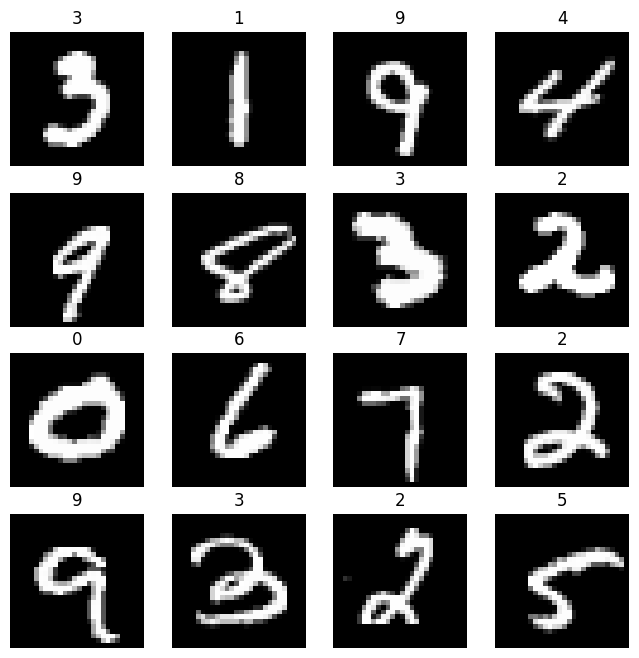

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
row, col = 4, 4

for i in range(1, row*col+1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(row, col, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis(False)

3. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

4. Recreate model_2 used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [35]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class cnn_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), 
            nn.ReLU(), 
            nn.Conv2d(hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)  
        return x
    

model = cnn_model(input_shape=1, output_shape=10, hidden_units=5).to(device)
print(model)

cnn_model(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=245, out_features=10, bias=True)
  )
)


5. Train the model on CPU and see how long it takes on each.

In [20]:
device

'cpu'

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [37]:
from timeit import default_timer as timer 
import torch.optim.optimizer
from tqdm.auto import tqdm
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task='multiclass', num_classes=10)
def train_step(
        model:nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim.Optimizer, 
        loss_fn: nn.Module, 
        accuracy_fn,
        device: torch.device= device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss
        train_acc += accuracy_fn(logits.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(dataloader)
    train_loss /= len(dataloader)
    print(f"train loss: {train_loss:.5f} | train accuracy: {train_acc*100:.2f}%")

def test_step(
        model:nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim.Optimizer, 
        loss_fn: nn.Module, 
        accuracy_fn,
        device: torch.device= device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss
            test_acc += accuracy_fn(logits.argmax(dim=1), y)

        test_acc /= len(dataloader)
        test_loss /= len(dataloader)
        print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc*100:.2f}%")

In [38]:
train_start_time = timer()

epochs = 3

for i in tqdm(range(epochs)):
    print(f"Epoch:{i+1}\n-------------------------")
    train_step(model, train_loader, optimizer, loss_fn, accuracy_fn, device=device)
    test_step(model, test_loader, optimizer, loss_fn, accuracy_fn, device=device)

train_end_time = timer()

print(f"model took {train_end_time-train_start_time:.3f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
-------------------------
train loss: 2.29962 | train accuracy: 11.22%


 33%|███▎      | 1/3 [02:23<04:47, 143.62s/it]

test loss: 2.29074 | test accuracy: 11.35%
Epoch:1
-------------------------
train loss: 1.18214 | train accuracy: 60.00%


 67%|██████▋   | 2/3 [04:36<02:17, 137.24s/it]

test loss: 0.37371 | test accuracy: 88.18%
Epoch:2
-------------------------
train loss: 0.23390 | train accuracy: 92.95%


100%|██████████| 3/3 [06:42<00:00, 134.19s/it]

test loss: 0.18480 | test accuracy: 94.08%
model took 402.597


6. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

In [45]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]}")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2


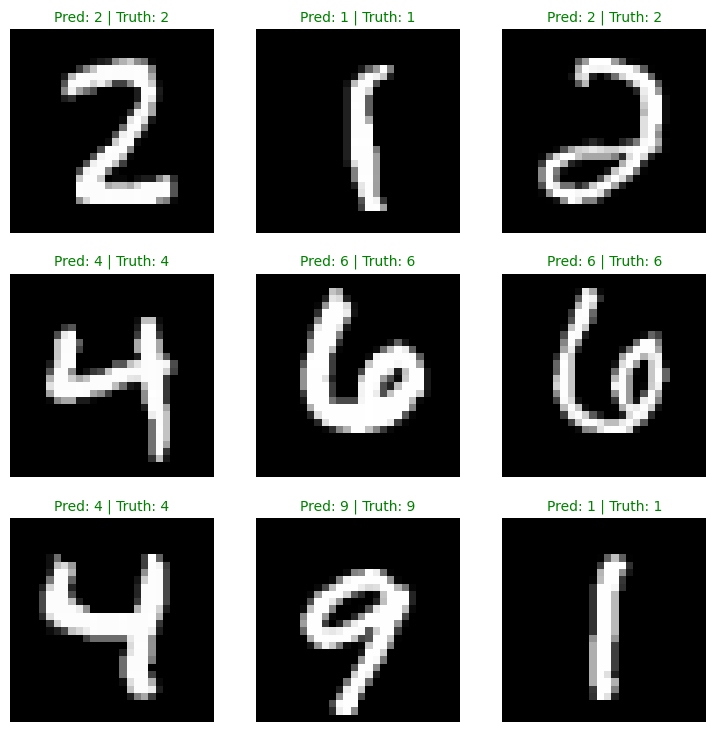

In [ ]:
preds = []
for image in test_samples:
    model.eval()
    with torch.inference_mode():
        image = torch.unsqueeze(image, dim=0).to(device)
        pred = model(image)
        preds.append(torch.argmax(pred, dim=1).unsqueeze(dim=0))


plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = preds[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = test_labels[i] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label.item()} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

7. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [52]:
test_preds = []

for X, y in tqdm(test_loader, desc="Making predictions"):
    model.eval()
    with torch.inference_mode():
        preds = model(X)
        test_preds.append(torch.argmax(preds, dim=1))
test_preds_tensor = torch.cat(test_preds)


Making predictions: 100%|██████████| 313/313 [00:08<00:00, 37.59it/s]


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

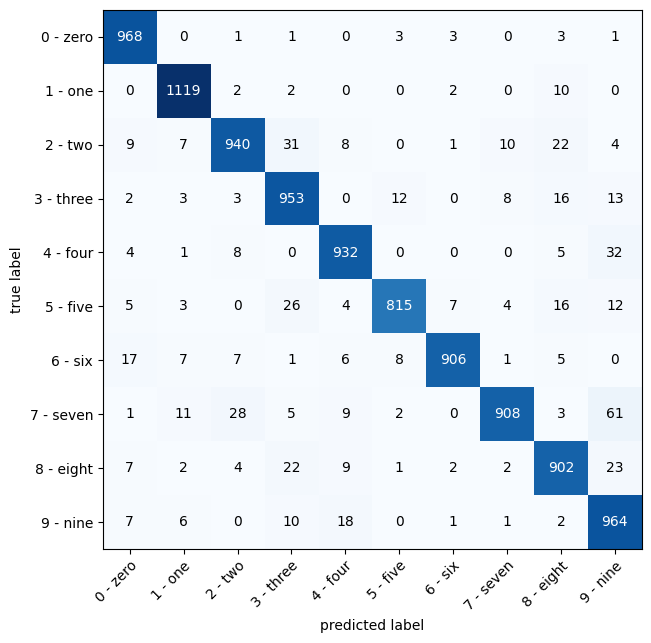

In [53]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix = ConfusionMatrix(num_classes=10, task='multiclass')
confusion_tensor = confusion_matrix(preds=test_preds_tensor, target=test_data.targets)

plot_confusion_matrix(conf_mat=confusion_tensor.numpy(), class_names=test_data.classes, figsize=(10, 7))

In [54]:
torch.save(model.state_dict(), 'cnn-for-MNIST.pth')

In [56]:
loaded_model = cnn_model(1, 5, 10)

loaded_model.load_state_dict(torch.load(f='cnn-for-MNIST.pth'))

C:\Users\newah\AppData\Local\Temp\ipykernel_536\328087427.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f='cnn-for-MNIST.pth'))

<All keys matched successfully>